Görüntü işleme ,aritmetik hesaplama ve verileri görselleştirme gibi işlemler için gerekli kütüphaneleri ekliyoruz.

In [ ]:
import pandas as pd
import numpy as np

from glob import glob
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from PIL import Image

plt.style.use('ggplot')

In [ ]:
!apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (4,798 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 121658 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

Bir metin ayıklama yazılımı olan **Tesseract**'ın kurulumu

In [ ]:
!pip install pytesseract

annot.parquet görüntü metin etiketlemeleri içindir, dataset içindeki annot.csv dosyasıyla aynı bilgileri içerir.

img.parquet ise görüntülerin meta verisine sahiptir. dataset'deki img.csv ile aynı, ancak Parquet formatında.

In [ ]:
annot = pd.read_parquet('/content/drive/MyDrive/text detection/annot.parquet')
imgs = pd.read_parquet('/content/drive/MyDrive/text detection/img.parquet')
img_fns = glob('/content/drive/MyDrive/text detection/train_images/*')


Görüntü görselleştirme:

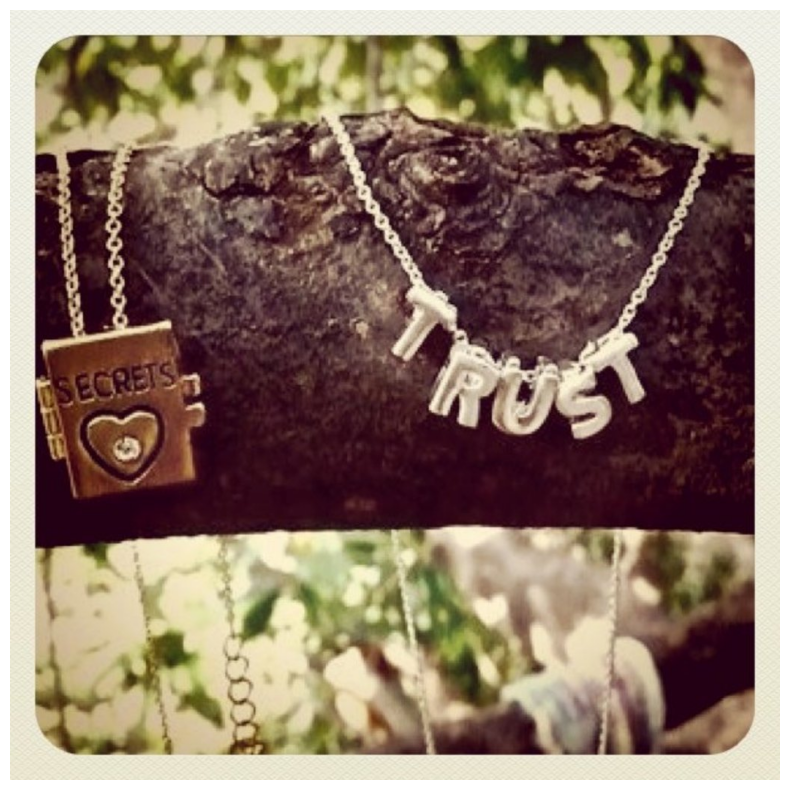

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(plt.imread(img_fns[0]))
ax.axis('off')
plt.show()

Metin etiketinin ID'si ,resim ID'si, utf8_string gibi bize metin ayıklamada yardımcı olabilecek imgeye ait bilgileri verir.

In [ ]:
image_id = img_fns[0].split('/')[-1].split('.')[0]
annot.query('image_id == @image_id')

,id,image_id,bbox,utf8_string,points,area
396920,00a1568f9906eaa8_1,00a1568f9906eaa8,"[49.32, 457.7, 176.1, 76.88]",SECRETS,"[49.32, 487.93, 216.22, 457.7, 225.42, 505.01,...",13538.57
396921,00a1568f9906eaa8_2,00a1568f9906eaa8,"[469.27, 346.53, 414.44, 234.2]",TRUST,"[544.06, 346.53, 631.12, 415.19, 688.75, 450.7...",97061.85


Verisetinden seçilen 25 resim aynı düzlem üzerinden görselleştirilir

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
axs = axs.flatten()
for i in range(25):
    axs[i].imshow(plt.imread(img_fns[i]))
    axs[i].axis('off')
    image_id = img_fns[i].split('/')[-1].rstrip('.jpg')
    n_annot = len(annot.query('image_id == @image_id'))
    axs[i].set_title(f'{image_id} - {n_annot}')
plt.show()

Tesseract OCR nin Phyton ile kullanılması için arayüz sağlanır, metin ayıklamada kullanılacak olan dil İngilizce olarak ayarlanır.

In [ ]:
import pytesseract

print(pytesseract.image_to_string(img_fns[11], lang='eng'))

Seçilen resimlerden indexi 11 olan,yani 12. resmi görüntüler,eksen çizgileri kaldırılır.

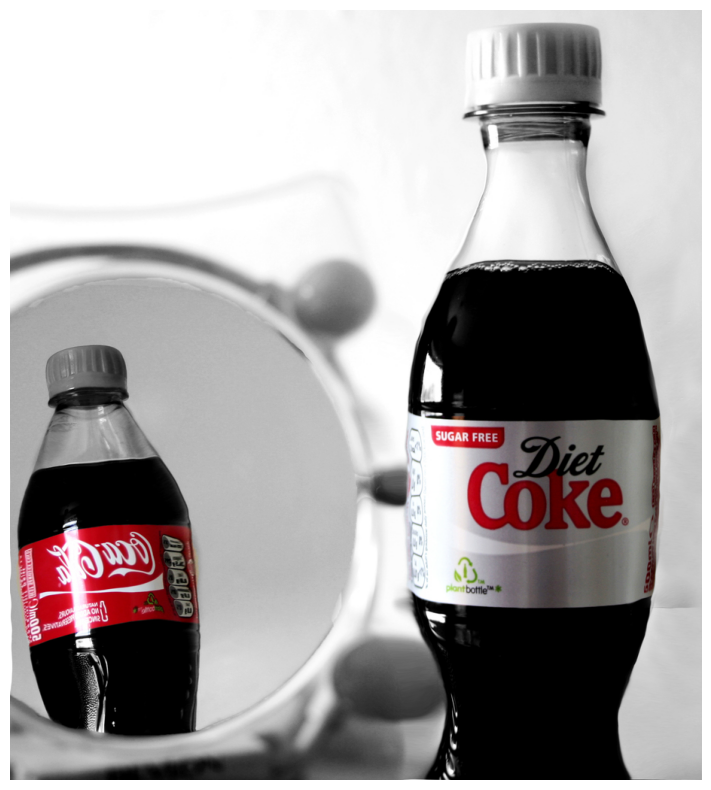

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(plt.imread(img_fns[11]))
ax.axis('off')
plt.show()

Keras OCR yüklenir:

In [ ]:
!pip install keras-ocr -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 83.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.3 MB/s eta 0:00:00


Keras içe aktarılır ve pipeline adında metin tanımlama bileşenlerini içeren bir yapı oluşturulur.

In [ ]:
import keras_ocr
pipeline = keras_ocr.pipeline.Pipeline()


Looking for /root/.keras-ocr/craft_mlt_25k.h5


Instructions for updating:
Use `tf.image.resize(...method=ResizeMethod.BILINEAR...)` instead.


Looking for /root/.keras-ocr/crnn_kurapan.h5


Seçilen 12. resmin metin tanımlamaları yapılır ve metinler konumlarıyla birlikte results değişkenine aktarılır.

In [ ]:
results = pipeline.recognize([img_fns[11]])


1/1 [==============================] - 3s 3s/step


Eldeki metin ve konum bilgileri Pandas Dataframe ile tablo haline getirilir.

In [ ]:
pd.DataFrame(results[0], columns=['text', 'bbox'])

,text,bbox
0,sugar,"[[565.1492, 558.1658], [612.5442, 560.6603], [..."
1,free,"[[613.0, 561.0], [651.0, 561.0], [651.0, 576.0..."
2,diet,"[[677.39636, 566.3701], [798.66064, 568.9502],..."
3,coke,"[[614.95667, 601.7782], [823.9369, 608.8623], ..."
4,,"[[534.0, 670.0], [555.0, 670.0], [555.0, 764.0..."
5,s,"[[200.78378, 701.7027], [228.02704, 697.1622],..."
6,d,"[[843.0, 765.0], [850.0, 765.0], [850.0, 775.0..."
7,bofle,"[[605.0, 765.0], [643.0, 765.0], [643.0, 778.0..."
8,s,"[[17.268291, 783.4147], [37.682926, 781.14636]..."
9,on,"[[107.0, 794.0], [119.0, 794.0], [119.0, 804.0..."


Elde edilen tanımlamalar ilgili resim üzerinde görselleştirilir.

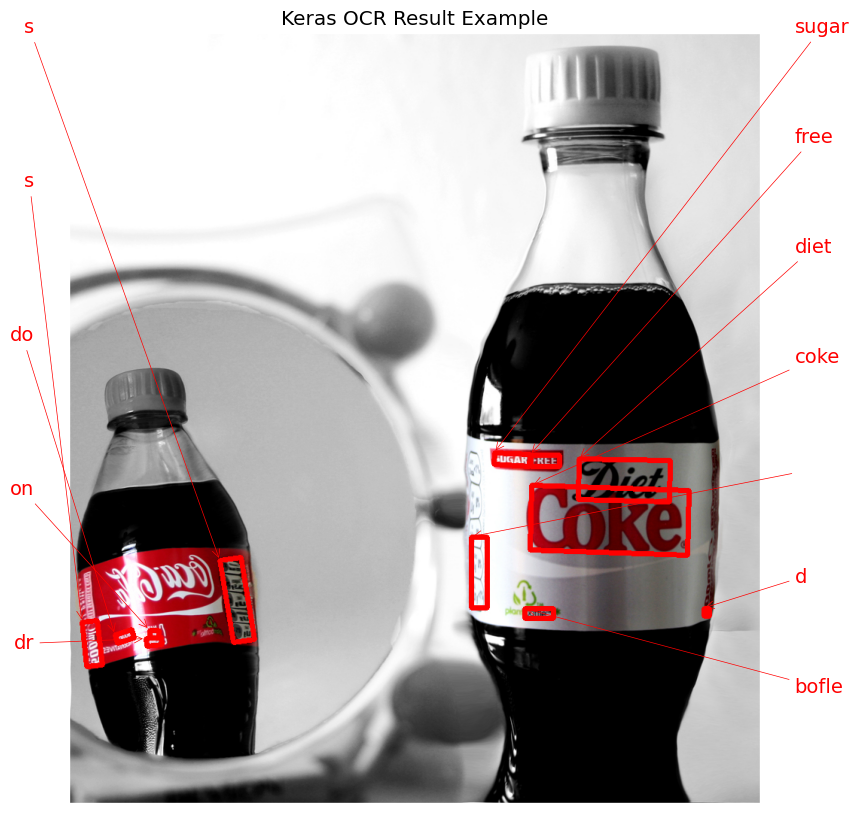

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
keras_ocr.tools.drawAnnotations(plt.imread(img_fns[11]), results[0], ax=ax)
ax.set_title('Keras OCR Result Example')
plt.show()

25 resim sırayla işlenir.

In [ ]:
pipeline = keras_ocr.pipeline.Pipeline()

dfs = []
for img in tqdm(img_fns[:25]):
    results = pipeline.recognize([img])
    result = results[0]
    img_id = img.split('/')[-1].split('.')[0]
    img_df = pd.DataFrame(result, columns=['text', 'bbox'])
    img_df['img_id'] = img_id
    dfs.append(img_df)
kerasocr_df = pd.concat(dfs)

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5


  0%|          | 0/25 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 0s 185ms/step


1/1 [==============================] - 3s 3s/step


Belirli bir görüntü üzerinde Keras OCR tarafından yapılan metin tanıma sonuçlarını ve bu sonuçları görsel olarak karşılaştırmak için tasarlanmış bir fonksiyon içerir.

In [ ]:
def plot_compare(img_fn, kerasocr_df):
    img_id = img_fn.split('/')[-1].split('.')[0]
    fig, axs = plt.subplots(1, 1, figsize=(15, 10))

    keras_results = kerasocr_df.query('img_id == @img_id')[['text','bbox']].values.tolist()
    keras_results = [(x[0], np.array(x[1])) for x in keras_results]
    keras_ocr.tools.drawAnnotations(plt.imread(img_fn),
                                    keras_results, ax=axs)
    axs.set_title('keras_ocr results', fontsize=24)
    plt.show()

İlgili 25 resmin Keras OCR sonuçları karşılaştırılır.

In [ ]:
# Loop over results
for img_fn in img_fns[:25]:
    plot_compare(img_fn, kerasocr_df)